In [5]:
import numpy as np
import numpy.random as R
import math
import matplotlib.pyplot as plt
from scipy.stats import qmc
import global_as_gaussian_quad as global_as_gaussian_quad

epsilon = 0.001
def dFunc(x):
    chi = x.shape[0]
    xe = np.tile(x.transpose(), dim).transpose()+np.repeat(np.array(np.identity(dim)*epsilon), chi, axis=0)
    return ((Func(xe)-np.tile(Func(x),dim))/epsilon).reshape(dim,chi)

def dFunc0(x,Func,M2,shiftedSobol=True):
    chi,dim = x.shape[0],x.shape[1]
    temp = np.zeros((dim,chi*M2))

    if(shiftedSobol == True):
        rand_add = qmc.Sobol(dim, scramble=False).random(M2+1)[1:]        
        for i in range(M2):       
            xe = np.tile(x.transpose(), dim).transpose()*(1-np.repeat(np.array(np.identity(dim)), chi, axis=0))
            rand = (x+rand_add[i])%1
            xe += rand.T.reshape(dim*chi,1)*np.repeat(np.array(np.identity(dim)), chi, axis=0)
            temp[:,i*(chi):(i+1)*(chi)] = ((Func(xe)-np.tile(Func(x),dim))/np.sum(xe-np.tile(x.transpose(),dim).transpose(),axis=1)).reshape(dim,chi)
            
    else:
        for i in range(M2):       
            xe = np.tile(x.transpose(), dim).transpose()*(1-np.repeat(np.array(np.identity(dim)), chi, axis=0))
            rand = R.uniform(0,1,(chi,dim))
            xe += rand.T.reshape(dim*chi,1)*np.repeat(np.array(np.identity(dim)), chi, axis=0)
            temp[:,i*(chi):(i+1)*(chi)] = ((Func(xe)-np.tile(Func(x),dim))/np.sum(xe-np.tile(x.transpose(),dim).transpose(),axis=1)).reshape(dim,chi)    
    return temp

In [2]:
#Liberian lower and upper parameter bounds
lb_L = np.array([.1, .1, .05, .41, .0276, .081, .25, .0833])
ub_L = np.array([.4, .4, .2, 1, .1702, .21, .5, .7])
#Sierra Leone bounds
lb_S = np.array([.1, .1, .05, .41, .0275, .1236, .25, .0833])
ub_S = np.array([.4, .4, .2, 1, .1569, .384, .5, .7])

def Func(x1):  
    x = lb_L + x1*(ub_L-lb_L)
    b1 = x[:,0]; b2 = x[:,1]; b3 = x[:,2]; r1 = x[:,3]
    g1 = x[:,4]; g2 = x[:,5]; om = x[:,6]; p = x[:,7]
    return (b1 + b2*r1*g1/om + b3*p/g2)/(g1 + p)
#labels for plots
in_labels = [r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\rho_1$', r'$\gamma_1$',\
            r'$\gamma_2$', r'$\omega$', r'$\psi$']
out_labels = ['Liberia', 'Sierra Leone']

In [3]:
# Active Subspace 
dim = 8
chi = 10000
epsilon = 0.001
z = R.uniform(0, 1, (chi, dim))

deriv = dFunc(z)
deriv /= np.sqrt(chi)
u0, s0, vh0 = np.linalg.svd(deriv.astype(float), full_matrices=True)   

s0 = s0**2
print('Cumulative explained variance (first 10):',(np.cumsum(s0)/np.sum(s0))[:10])
print('The 1st eigenvector (first 10):',u0[:10,0])

Cumulative explained variance (first 10): [0.76725399 0.96571737 0.98485061 0.99506325 0.99854547 0.99965141
 0.99994036 1.        ]
The 1st eigenvector (first 10): [-0.38472183 -0.06250973 -0.34291083 -0.04408793  0.25306107  0.30165949
  0.03871396  0.75631537]


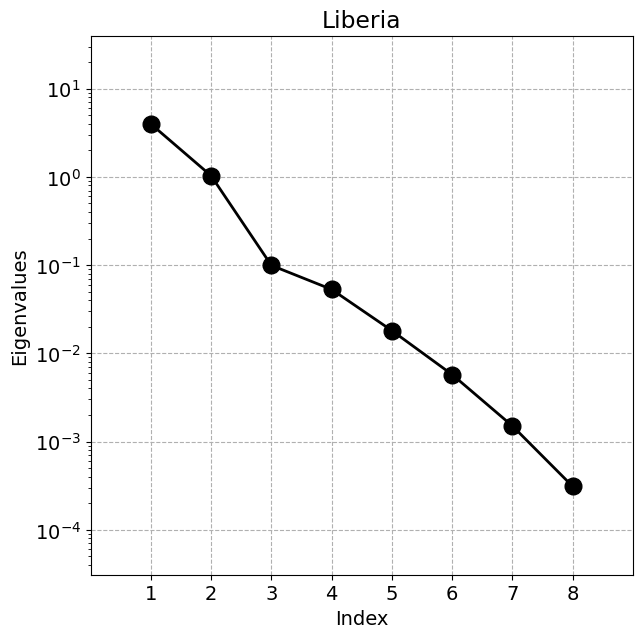

In [11]:
plt.rcParams['font.size'] = 14
plt.figure(figsize=(7,7))
plt.rc('font')
k = s0.shape[0]
plt.semilogy(range(1 ,k+1), s0, 'ko-',markersize=12,linewidth=2)
plt.xlabel('Index')
plt.ylabel('Eigenvalues')
plt.title('Liberia')
plt.grid(True,linestyle = '--')
plt.xticks(range(1, k+1))
plt.axis([0, k+1, 0.1*np.amin(s0), 10*np.amax(s0)])

plt.show()

In [8]:
# GAS
dim = 8
chi = 10000
M2=10

z = R.uniform(0, 1, (int(chi/M2), dim))
deriv = dFunc0(z, Func, M2)
deriv /= np.sqrt(chi)
#u, s, vh = np.linalg.svd(deriv.astype(float), full_matrices=True) 
M2 = 10
fd_result = global_as_gaussian_quad.calculate_finite_difference_matrix(
            f=Func,
            X=R.uniform(0, 1, (int(chi/2/M2), dim)),
            n_points=M2
        )
u, s, _ = np.linalg.svd(fd_result.T.astype(float), full_matrices=False)  
s = s**2
print('Cumulative explained variance (first 10):',(np.cumsum(s)/np.sum(s))[:10])
print('The 1st eigenvector (first 10):',u[:10,0])

Cumulative explained variance (first 10): [0.83116664 0.9539976  0.97822078 0.99277726 0.99714597 0.99959347
 0.9999554  1.        ]
The 1st eigenvector (first 10): [-0.4591155  -0.07542471 -0.47560704 -0.05153546  0.27568708  0.38775224
  0.04338058  0.57133972]


In [10]:
s/sum(s)

array([8.31166642e-01, 1.22830958e-01, 2.42231828e-02, 1.45564789e-02,
       4.36871194e-03, 2.44749806e-03, 3.61931069e-04, 4.45973105e-05])

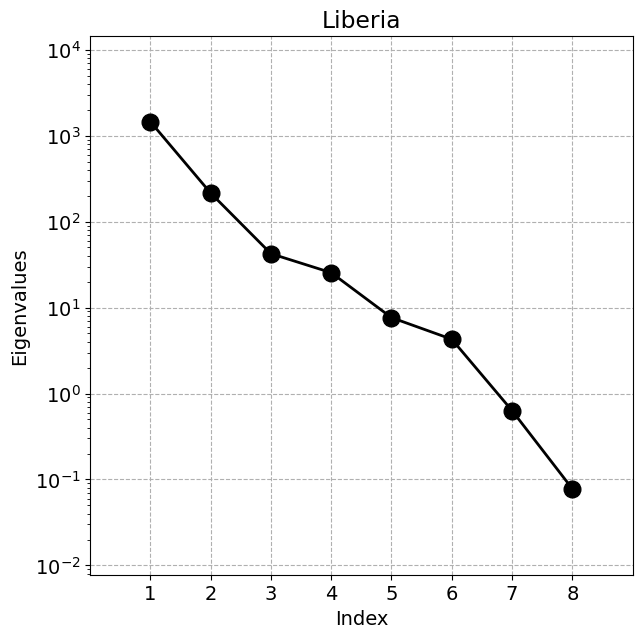

In [12]:
plt.rcParams['font.size'] = 14
plt.figure(figsize=(7,7))
plt.rc('font')
k = s.shape[0]
plt.semilogy(range(1 ,k+1), s, 'ko-',markersize=12,linewidth=2)
plt.xlabel('Index')
plt.ylabel('Eigenvalues')
plt.title('Liberia')
plt.grid(True,linestyle = '--')
plt.xticks(range(1, k+1))
plt.axis([0, k+1, 0.1*np.amin(s), 10*np.amax(s)])

plt.savefig(f'gas_paper/lib1.png')

Change u0 to u below to get results of GAS method.

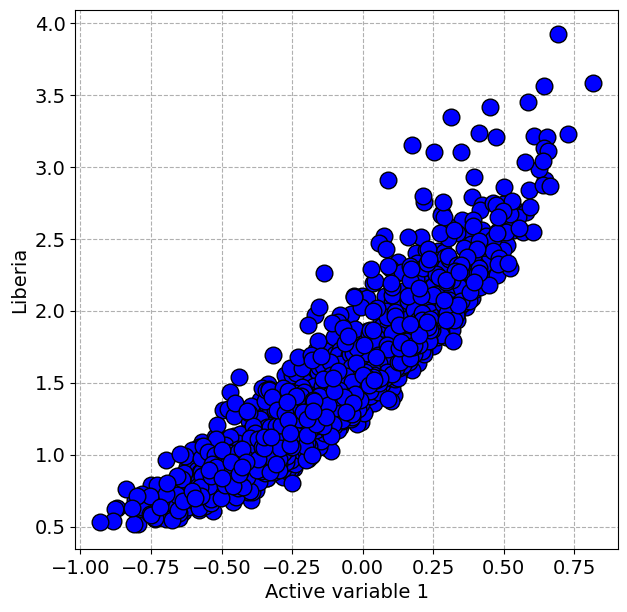

In [15]:
dim = 8
chi = 2000
z = R.uniform(0, 1, (chi, dim))
f = Func(z)
y1 = np.dot(z,-u[:,0])
y2 = np.dot(z,-u[:,1])

out_label = 'Liberia'
plt.figure(figsize=(7,7))
plt.rc('font')
plt.plot(y1, f, 'o', markersize=12,markerfacecolor='b', markeredgecolor='black')
plt.xlabel('Active variable 1')
plt.ylabel(out_label)
plt.grid(True,linestyle = '--')
plt.savefig(f'gas_paper/lib2.png')

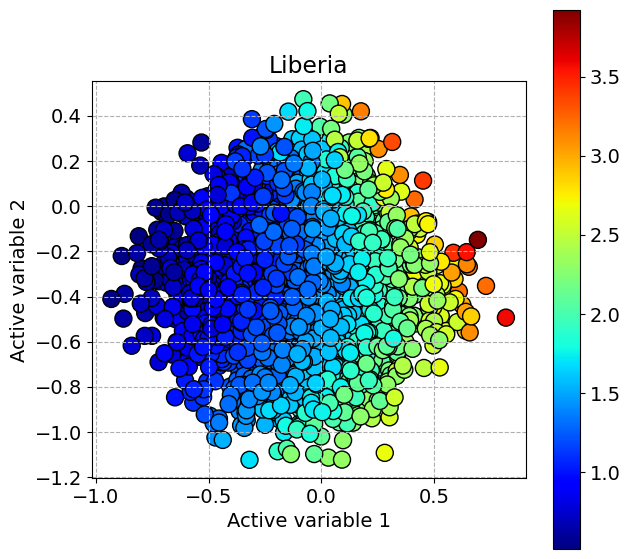

In [16]:
plt.figure(figsize=(7,7))
plt.rc('font')
plt.axes().set_aspect('equal')
plt.scatter(y1, y2, c=f, s=150.0, vmin=np.min(f), vmax=np.max(f),cmap = 'jet', edgecolors='black')
plt.xlabel('Active variable 1')
plt.ylabel('Active variable 2')
ymin = 1.1*np.amin([np.amin(y1), np.amin(y2)])
ymax = 1.1*np.amax([np.amax(y1), np.amax(y2)])
plt.grid(True,linestyle = '--')
plt.title(out_label)
plt.colorbar()
plt.savefig(f'gas_paper/lib3.png')

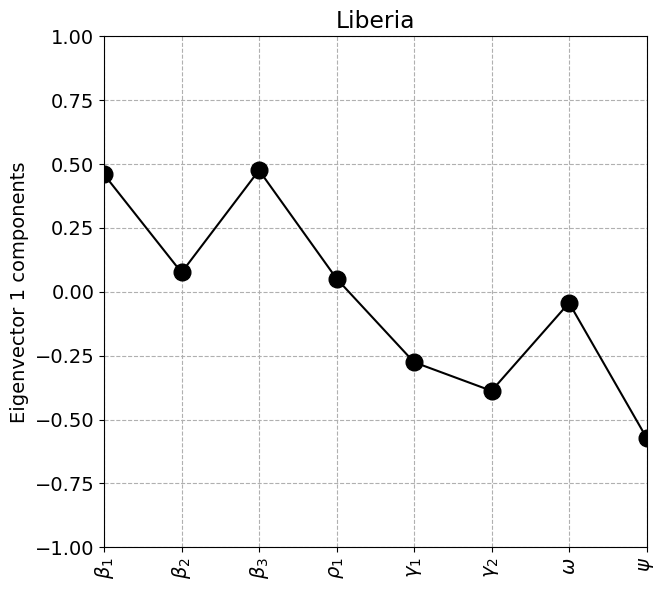

In [17]:
m = 8
plt.figure(figsize=(7,7))
plt.rc('font')
plt.plot(range(1, m+1), -u[:,0], 'ko-', markersize=12)
plt.ylabel('Eigenvector 1 components')
plt.title(out_label)
plt.grid(True,linestyle = '--')
plt.xticks(range(1, m+1), in_labels, rotation='vertical')
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)
plt.axis([1, m, -1, 1])
plt.savefig(f'gas_paper/lib4.png')